In [3]:
import prickle as pk
from prickle import load_hdf5, find_trades, interpolate, imshow, reorder, plot_trades, nodups
from urllib.request import urlretrieve
from pathlib import Path
import gzip
import shutil
import h5py

In [4]:
types = {0: 'add',
         1: 'add_mpid',
         2: 'cancel',
         3: 'delete',
         4: 'exec',
         5: 'exec_p',
         6: 'replace'}

In [5]:
data_path = Path('/drive/data/algo_trading/data/itch')

In [44]:
name = 'AAPL'
hdf = data_path / 'itch3.hdf5'

In [49]:
messages = load_hdf5(hdf, grp='messages', name=name)
messages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685113 entries, 0 to 1685112
Data columns (total 8 columns):
sec         1685113 non-null int32
nano        1685113 non-null int32
type        1685113 non-null int32
side        1685113 non-null int32
price       1685113 non-null int32
shares      1685113 non-null int32
refno       1685113 non-null int32
newrefno    1685113 non-null int32
dtypes: int32(8)
memory usage: 64.3 MB


In [50]:
messages.type = messages.type.map(types)
messages.type.value_counts()

add         755991
delete      724493
replace     126266
exec         51129
cancel       15196
add_mpid     10397
exec_p        1641
Name: type, dtype: int64

In [53]:
messages['hr'] = messages.sec.div(60**2).astype(int)
messages.groupby('type').hr.describe().unstack()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
add,755991.0,37.954859,22.449182,0.0,19.0,37.0,57.0,78.0
add_mpid,10397.0,39.051938,24.825575,0.0,15.0,35.0,60.0,78.0
cancel,15196.0,38.610687,22.662682,0.0,19.0,39.0,58.0,78.0
delete,724493.0,38.643062,21.964278,0.0,20.0,40.0,57.0,78.0
exec,51129.0,37.869154,22.578142,0.0,18.0,37.0,58.0,78.0
exec_p,1641.0,35.591712,22.737184,0.0,15.0,34.0,55.0,78.0
replace,126266.0,37.980446,22.593738,0.0,18.0,38.0,58.0,78.0


/home/stefan/.pyenv/versions/3.5.5/envs/algo_trading/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


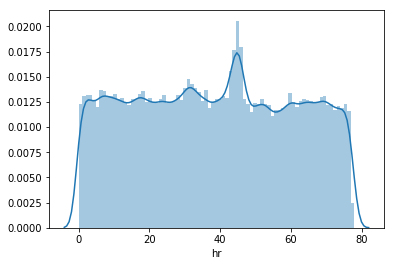

In [56]:
import seaborn as sns
sns.distplot(messages.hr, bins=79);

In [47]:
price, volume = load_hdf5(hdf, grp='books', name=name)
orders = pd.concat([price, volume.iloc[:, 2:]], axis=1).drop_duplicates()
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1703594 entries, 0 to 1811378
Data columns (total 22 columns):
sec         int32
nano        int32
bidprc.1    int32
bidprc.2    int32
bidprc.3    int32
bidprc.4    int32
bidprc.5    int32
askprc.1    int32
askprc.2    int32
askprc.3    int32
askprc.4    int32
askprc.5    int32
bidvol.1    int32
bidvol.2    int32
bidvol.3    int32
bidvol.4    int32
bidvol.5    int32
askvol.1    int32
askvol.2    int32
askvol.3    int32
askvol.4    int32
askvol.5    int32
dtypes: int32(22)
memory usage: 156.0 MB


In [26]:
messages['time'] = messages.sec + messages.nano / 10 ** 9
orders['time'] = orders.sec + orders.nano / 10 ** 9

In [33]:
data = orders.drop(['sec', 'nano'], axis=1).merge(messages.drop(['sec', 'nano'], axis=1), how='left')
data = data.drop_duplicates().sort_values('time')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1330777 entries, 1260263 to 297275
Data columns (total 27 columns):
bidprc.1    1330777 non-null int32
bidprc.2    1330777 non-null int32
bidprc.3    1330777 non-null int32
bidprc.4    1330777 non-null int32
bidprc.5    1330777 non-null int32
askprc.1    1330777 non-null int32
askprc.2    1330777 non-null int32
askprc.3    1330777 non-null int32
askprc.4    1330777 non-null int32
askprc.5    1330777 non-null int32
bidvol.1    1330777 non-null int32
bidvol.2    1330777 non-null int32
bidvol.3    1330777 non-null int32
bidvol.4    1330777 non-null int32
bidvol.5    1330777 non-null int32
askvol.1    1330777 non-null int32
askvol.2    1330777 non-null int32
askvol.3    1330777 non-null int32
askvol.4    1330777 non-null int32
askvol.5    1330777 non-null int32
time        1330777 non-null float64
type        1330777 non-null object
side        1330777 non-null int32
price       1330777 non-null int32
shares      1330777 non-null int32
refn

In [34]:
data.head()

,bidprc.1,bidprc.2,bidprc.3,bidprc.4,bidprc.5,askprc.1,askprc.2,askprc.3,askprc.4,askprc.5,...,askvol.3,askvol.4,askvol.5,time,type,side,price,shares,refno,newrefno
1260263,1660200,1660000,1659900,1659500,1658800,1661500,1662000,1662300,1663000,1663500,...,100,64,50,0.066074,delete,1,1659800,100,262537097,-1
137507,1674400,1674300,1674200,1674100,1674000,1674700,1674800,1674900,1675000,1675100,...,601,3629,700,0.335094,delete,-1,1674600,100,28048321,-1
189654,1679200,1679000,1678900,1678800,1678700,1679400,1679500,1679600,1679700,1679800,...,300,400,701,0.563421,delete,1,1679100,500,44011601,-1
362612,1669900,1669800,1669700,1669600,1669500,1670000,1670100,1670200,1670300,1670400,...,1100,200,500,0.749020,replace,-1,1671300,10,95548029,95557709
1117916,1677800,1677700,1677600,1677500,1677400,1678000,1678100,1678200,1678300,1678400,...,500,601,501,0.753677,delete,-1,1678000,400,250206985,-1


In [41]:
book['price'].head()

,sec,nano,bidprc.1,bidprc.2,bidprc.3,bidprc.4,bidprc.5,askprc.1,askprc.2,askprc.3,askprc.4,askprc.5,time
1036392,0,66074404,1660200,1660000,1659900,1659500,1658800,1661500,1662000,1662300,1663000,1663500,0.066074
107988,0,335093715,1674400,1674300,1674200,1674100,1674000,1674700,1674800,1674900,1675000,1675100,0.335094
154950,0,563421357,1679200,1679000,1678900,1678800,1678700,1679400,1679500,1679600,1679700,1679800,0.563421
302184,0,749020283,1669900,1669800,1669700,1669600,1669500,1670000,1670100,1670200,1670300,1670400,0.749020
302185,0,749020283,1669900,1669800,1669700,1669600,1669500,1670000,1670100,1670200,1670300,1670400,0.749020


In [44]:
 pd.to_timedelta(book['price'].time, unit='s').describe()

count                   1091233
mean     1 days 14:57:48.401368
std      0 days 22:14:18.613984
min      0 days 00:00:00.066073
25%      0 days 20:18:14.064972
50%      1 days 14:26:44.642895
75%      2 days 10:02:39.914978
max      3 days 06:11:14.873173
Name: time, dtype: object

In [31]:
volume.head()

,sec,nano,bidvol.1,bidvol.2,bidvol.3,bidvol.4,bidvol.5,askvol.1,askvol.2,askvol.3,askvol.4,askvol.5
0,215869,870968088,50,0,0,0,0,0,0,0,0,0
1,51984,869100827,50,0,0,0,0,145,0,0,0,0
2,51985,16229147,203,50,0,0,0,145,0,0,0,0
3,52384,391892251,203,29,50,0,0,145,0,0,0,0
4,52384,473746715,203,29,50,0,0,145,290,0,0,0


In [12]:
orders = pd.concat([price, volume.iloc[:, 2:]], axis=1).sort_index(1)

In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091233 entries, 0 to 1091232
Data columns (total 22 columns):
askprc.1    1091233 non-null int32
askprc.2    1091233 non-null int32
askprc.3    1091233 non-null int32
askprc.4    1091233 non-null int32
askprc.5    1091233 non-null int32
askvol.1    1091233 non-null int32
askvol.2    1091233 non-null int32
askvol.3    1091233 non-null int32
askvol.4    1091233 non-null int32
askvol.5    1091233 non-null int32
bidprc.1    1091233 non-null int32
bidprc.2    1091233 non-null int32
bidprc.3    1091233 non-null int32
bidprc.4    1091233 non-null int32
bidprc.5    1091233 non-null int32
bidvol.1    1091233 non-null int32
bidvol.2    1091233 non-null int32
bidvol.3    1091233 non-null int32
bidvol.4    1091233 non-null int32
bidvol.5    1091233 non-null int32
nano        1091233 non-null int32
sec         1091233 non-null int32
dtypes: int32(22)
memory usage: 91.6 MB


In [21]:
executions = orders.merge(messages[messages.type.isin(['exec', 'exec_p'])], how='left').dropna()
executions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352027 entries, 37 to 1363949
Data columns (total 28 columns):
askprc.1    352027 non-null int32
askprc.2    352027 non-null int32
askprc.3    352027 non-null int32
askprc.4    352027 non-null int32
askprc.5    352027 non-null int32
askvol.1    352027 non-null int32
askvol.2    352027 non-null int32
askvol.3    352027 non-null int32
askvol.4    352027 non-null int32
askvol.5    352027 non-null int32
bidprc.1    352027 non-null int32
bidprc.2    352027 non-null int32
bidprc.3    352027 non-null int32
bidprc.4    352027 non-null int32
bidprc.5    352027 non-null int32
bidvol.1    352027 non-null int32
bidvol.2    352027 non-null int32
bidvol.3    352027 non-null int32
bidvol.4    352027 non-null int32
bidvol.5    352027 non-null int32
nano        352027 non-null int32
sec         352027 non-null int32
type        352027 non-null object
side        352027 non-null float64
price       352027 non-null float64
shares      352027 non-null floa

In [24]:
orders.sec.sort_values().head()

919678    0
302185    0
107988    0
154950    0
302184    0
Name: sec, dtype: int32

In [22]:
orders.nano.head()

0    870968088
1    869100827
2     16229147
3    391892251
4    473746715
Name: nano, dtype: int32

In [26]:
orders.time = pd.to_timedelta(orders.sec, unit='s')
orders.time.sort_values().describe()

count                   1091233
mean     1 days 14:57:47.900297
std      0 days 22:14:18.613532
min             0 days 00:00:00
25%             0 days 20:18:14
50%             1 days 14:26:44
75%             2 days 10:02:39
max             3 days 06:11:14
Name: sec, dtype: object

In [ ]:
messages['trading_date'] = pd.to_datetime(trading_date)
messages.time = messages.trading_date.add(messages.time)
messages.drop('trading_date', axis=1, inplace=True)
messages.head()